Дашборд: https://public.tableau.com/views/2_17010324210900/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link

Презентация:https://drive.google.com/file/d/1qxpVo0WipmMx58dI4RMEj-P3h-nKrfJ1/view?usp=sharing

# Банки — анализ оттока клиентов


# Описание проекта

У нас есть датасет с данными о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Используя эти данные, необходимо проанализировать клиентов регионального банка и выделите сегменты клиентов,
которые склонны уходить из банка. Для этого нужно провести исследовательский анализ данных, определить все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравнить портреты типичных клиентов, которые
склонны и не склонны уходить из банка и т.д); проверить гипотезу различия дохода между теми клиентами, которые
ушли и теми, которые остались; сформулировать и проверить статистическую гипотезу относительно
представленных данных, которая поможет внести ясность в исследование; объединяя признаки отточности, сформировать сегменты, отобрать из них лучшие и дать по ним рекомендации. В завершение необходимо предоставить дашборд и презентацию с итогами исследования.

## Предобработка данных

### Подключение библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from scipy import stats as st
import math as mth
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from plotly import graph_objects as go

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [3]:
data

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Для последующей работы приведем названия столбцов к змеиному регистру, изменим тип данных у столбцов score и age на целочисленный. Также на данном шаге выявились пропуски в столбцах balance (2295, что составляет 23% от всех данных) и age (26). Разберемся с ними позже.

### Приведение названий столбцов к единому стилю

In [5]:
data.columns = data.columns.str.lower()
print(data.columns) 

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')


In [6]:
data = data.rename(columns={'userid':'user_id'})
print(data.columns)

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')


### Работа с некорректными значениями

Проверим, есть ли в банке клиенты младше 18 лет и без используемых банковских продуктов

In [7]:
# проверка отсутствия банковских продуктов
data[data['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


По всей видимости, клиент окончательно ушел из банка, на что указывает столбец churn и отсутствие банковских продуктов. Удалим эту строку.

In [8]:
data = data[data['products']>0]
data[data['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


In [9]:
# Проверка отсутствия несовершеннолетних клиентов
data[data['age']<18]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


Несовершеннолетние не могут являться клиентами банка, и таких у нас нет

### Удаление пропусков в столбце age

In [10]:
data.dropna(subset=['age'], inplace=True)
data = data.reset_index(drop=True)
display(data)
data.info()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9968,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9969,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9970,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9971,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9973 non-null   int64  
 1   score          9973 non-null   float64
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   float64
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   int64  
 9   last_activity  9973 non-null   int64  
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 935.1+ KB


Строки с пропусками в столбце age удалены, с ними исчезли 10 строк с пропусками в balance.

### Замена типов данных

In [11]:
data.score = data.score.astype(int)
data.age = data.age.astype(int)
display(data)
data.info()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9968,120553,814,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0
9969,139170,894,Ярославль,М,46,0,NaN,1,1,0,196898.29,0
9970,115639,903,Ярославль,М,24,0,NaN,2,1,1,108905.09,0
9971,148700,777,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9973 non-null   int64  
 1   score          9973 non-null   int64  
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   int64  
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   int64  
 9   last_activity  9973 non-null   int64  
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 935.1+ KB


In [12]:
data.to_excel('B:\PhotoGallery\data.xlsx')

### Работа с дубликатами

In [13]:
#проверим на наличие явных дубликатов
data.duplicated().sum()

0

In [14]:
#проверим на наличие дубликатов по столбцу user_id
data['user_id'].duplicated().sum()

50

Выявилось 50 дубликатов по user_id, посмотрим на них

In [15]:
user_dup = data[data.duplicated(subset=['user_id'])]
user_dup

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1582,190253,726,Ярославль,М,49,0,NaN,1,1,1,177700.78,0
1836,210662,896,Рыбинск,Ж,37,0,NaN,2,0,0,90916.04,0
2137,131419,739,Рыбинск,Ж,37,3,1307941.65,3,0,0,103867.47,0
2300,220816,934,Рыбинск,Ж,74,5,1294285.39,3,1,0,95606.80,0
2995,208081,821,Рыбинск,Ж,62,3,493608.26,2,1,1,33491.45,0
3036,170312,813,Рыбинск,Ж,47,3,370027.67,2,0,0,129835.56,0
3102,185748,912,Ярославль,Ж,47,5,1598218.98,2,0,0,180256.98,0
3813,211130,918,Рыбинск,Ж,55,0,NaN,2,1,1,244202.04,0
4182,217643,804,Рыбинск,Ж,40,2,301836.65,2,1,1,81137.22,0
4212,226719,903,Рыбинск,Ж,63,0,NaN,1,1,0,138582.58,0


Так как таких дублей мало относительно общего числа строк, то можно предположить, что клиенты меняли место жительства и начинали пользоваться банком в другом городе, а то, что в столбцах у дублей разный пол и т.д. может являться простой ошибкой. Но т.к.данные в столбцах сильно разнятся и мы не можем уверенно удалить их.

### Анализ пропусков в столбце balance

In [16]:
# Выясним, связаны ли пропуски в столбце balance с фактом оттока клиента из банка

data[data['balance'].isna()]['churn'].value_counts()

0    2266
1      12
Name: churn, dtype: int64

Лишь в 12 случаях пропуск мог быть связан с уходом клиента из банка, из чего следует вывод, что эти характеристики не связаны

In [17]:
# Посмотрим распределение пропусков по городам
data.query('balance.isna()').groupby('city')['city'].count()

city
Ростов        235
Рыбинск       585
Ярославль    1458
Name: city, dtype: int64

Больше всего пропусков в Ярославле, меньше всего в Ростове

In [18]:
# Проверим, есть ли нулевые остатки в поле balance
data.query('balance == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3896,179831,730,Ярославль,М,18,0,0.0,2,1,1,64548.33,0
6750,148456,813,Ярославль,М,20,2,0.0,2,1,0,23876.51,0


Если бы в столбце balance не было данных с нулевым остатком, то можно было бы принять пропуски за отсутствие денег на счету, но такие значения есть и придется оставить пропуски как есть. Заполнить пропуски средним или медианным значением будет некорректно.

In [19]:
# Вызовем метод describe и проанализируем часть датасета, содержащую пропуски:

display (data[data['balance'].isna()].describe())

# Сравним с результатом вызова метода describe для всего датасета:

display (data.describe())

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2278.000000,2278.000000,2278.000000,2278.000000,0.0,2278.000000,2278.000000,2278.000000,2.278000e+03,2278.000000
mean,171915.451273,865.314750,42.076822,0.050044,NaN,1.163740,0.815628,0.549166,2.264338e+05,0.005268
std,33306.706956,89.550489,11.919094,0.218083,NaN,0.403065,0.387873,0.497686,1.998249e+05,0.072404
min,114182.000000,642.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,2.027403e+04,0.000000
25%,142986.750000,871.000000,33.000000,0.000000,NaN,1.000000,1.000000,0.000000,1.202695e+05,0.000000
50%,172376.000000,903.000000,40.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.743542e+05,0.000000
75%,201258.500000,922.000000,49.000000,0.000000,NaN,1.000000,1.000000,1.000000,2.403970e+05,0.000000
max,229145.000000,990.000000,86.000000,1.000000,NaN,3.000000,1.000000,1.000000,1.333687e+06,1.000000


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9973.000000,9973.000000,9973.000000,9973.000000,7.695000e+03,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000
mean,171757.616966,848.671212,42.730773,2.630803,8.272456e+05,1.871653,0.680237,0.522912,1.477991e+05,0.182292
std,33696.365256,65.393153,12.175166,1.980060,1.980327e+06,0.792547,0.466408,0.499500,1.392871e+05,0.386105
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142757.000000,802.000000,33.000000,0.000000,2.956987e+05,1.000000,0.000000,0.000000,7.525202e+04,0.000000
50%,172651.000000,853.000000,40.000000,3.000000,5.242953e+05,2.000000,1.000000,1.000000,1.196431e+05,0.000000
75%,201164.000000,900.000000,51.000000,4.000000,9.800512e+05,2.000000,1.000000,1.000000,1.745000e+05,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Исходя из данных можно сделать вывод о том, что поьзователи с пропусками имеют значительно меньше объектов в собственности, их банковский рейтинг чуть ниже, они пользуются меньшим числом банковских продуктов, чуть более активны и имеют более высокую зарплату.

### Поиск аномалий

Взглянем на уникальные значения некоторых столбцов (возраста клиента и всех категориальных), посмотрим, есть ли явные аномалии:

In [20]:
for column in ['city', 'age', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn']:
    print(f'Уникальные значения столбца `{column}`: {np.sort(data[column].unique())}')

Уникальные значения столбца `city`: ['Ростов' 'Рыбинск' 'Ярославль']
Уникальные значения столбца `age`: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 86]
Уникальные значения столбца `gender`: ['Ж' 'М']
Уникальные значения столбца `equity`: [0 1 2 3 4 5 6 7 8 9]
Уникальные значения столбца `products`: [1 2 3 4 5]
Уникальные значения столбца `credit_card`: [0 1]
Уникальные значения столбца `last_activity`: [0 1]
Уникальные значения столбца `churn`: [0 1]


С этими столбцами всё в порядке

## Исследовательский анализ

Посмотрим на основные характеристики данных

In [21]:
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9973.000000,9973.000000,9973.000000,9973.000000,7.695000e+03,9973.000000,9973.000000,9973.000000,9.973000e+03,9973.000000
mean,171757.616966,848.671212,42.730773,2.630803,8.272456e+05,1.871653,0.680237,0.522912,1.477991e+05,0.182292
std,33696.365256,65.393153,12.175166,1.980060,1.980327e+06,0.792547,0.466408,0.499500,1.392871e+05,0.386105
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142757.000000,802.000000,33.000000,0.000000,2.956987e+05,1.000000,0.000000,0.000000,7.525202e+04,0.000000
50%,172651.000000,853.000000,40.000000,3.000000,5.242953e+05,2.000000,1.000000,1.000000,1.196431e+05,0.000000
75%,201164.000000,900.000000,51.000000,4.000000,9.800512e+05,2.000000,1.000000,1.000000,1.745000e+05,0.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


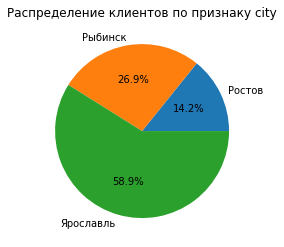

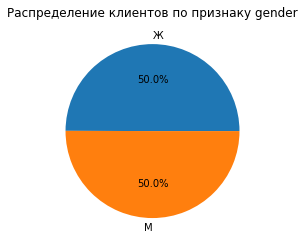

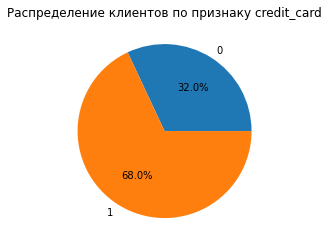

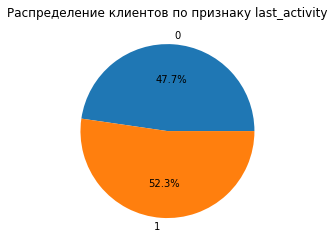

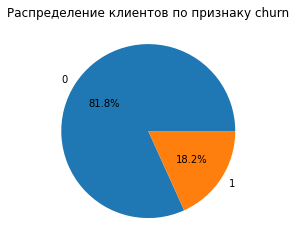

In [22]:
for column in ['city','gender','credit_card','last_activity','churn']:
    df = data.groupby(column).agg({'user_id': 'count'})
    fig1,ax1 = plt.subplots()
    ax1.pie(df['user_id'], labels=df.index, autopct='%1.1f%%')
    ax1.set_title(f'Распределение клиентов по признаку {column}')
    plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


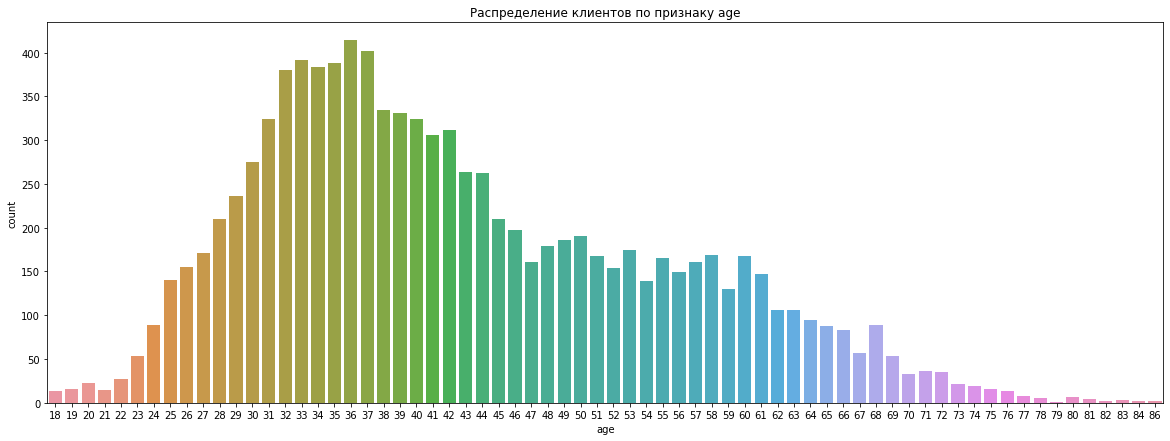

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


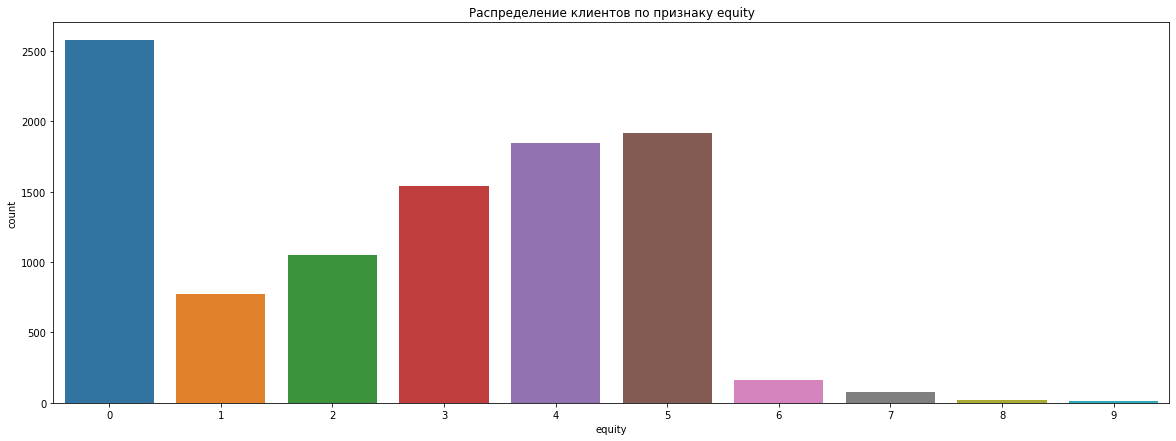

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


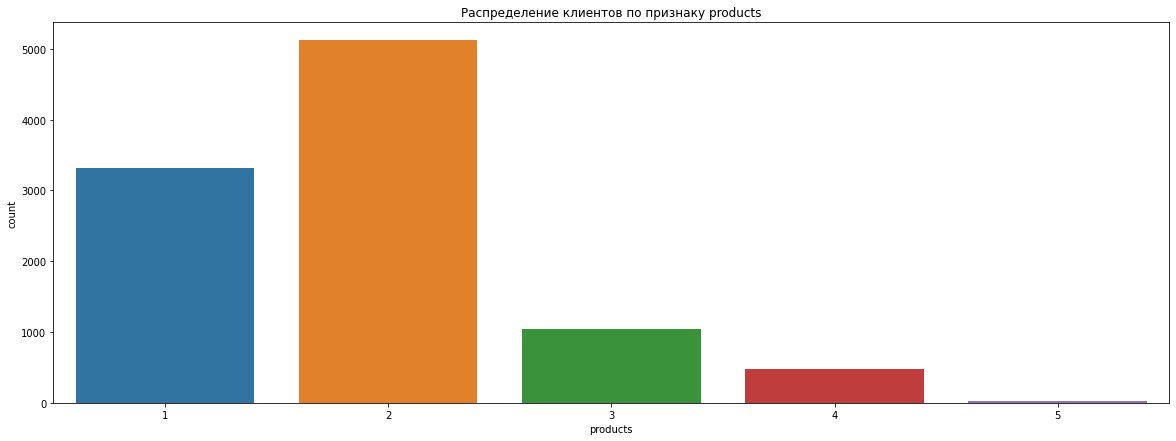

In [23]:
for column in ['age','equity', 'products']:
    plt.figure(figsize=(20,7))
    sns.countplot(data[column])
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.show()

Всего в отток попало 18% клиентов; клиентами являются люди от 18 до 86 лет, средний возраст - 43 года; средний балл кредитного скоринга - 849, минимальный - 642, максимальный - 1000; 68% клинтов имеют кредитную карту; активных клиентов 52%; чаще всего клиентами являются люди без собственности; половина клиентов пользуется двумя продуктами банка.

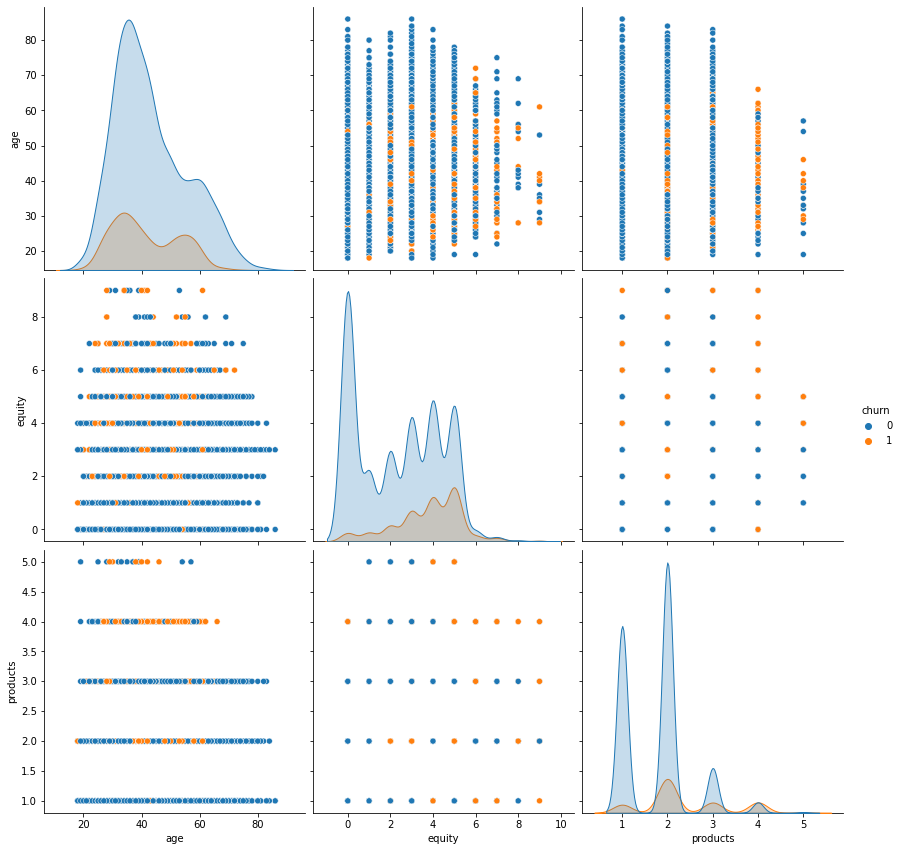

In [24]:
sns.pairplot(data[['age','equity', 'products','churn']], hue='churn', height=4);

Из графиков видно, что чаще всего люди уходят в возрасте от 20 до 40 лет. Заметно, что люди от 40 лет, пользующиеся 4-мя банковскими продуктами и имеют в собственности больше 5 объектов, уходят чаще. Самый большой отток заметен среди клиентов с двумя продуктами банка в возрасте от 40 до 60.

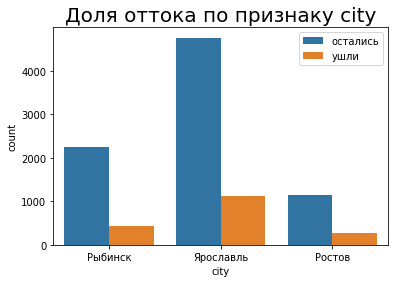

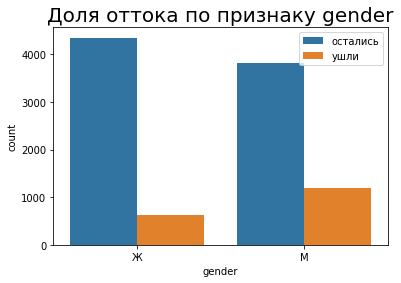

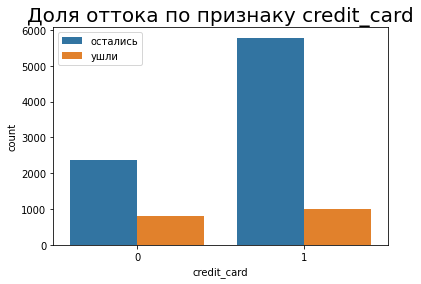

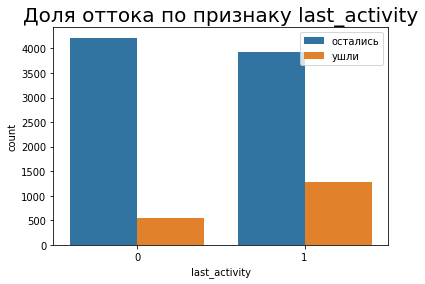

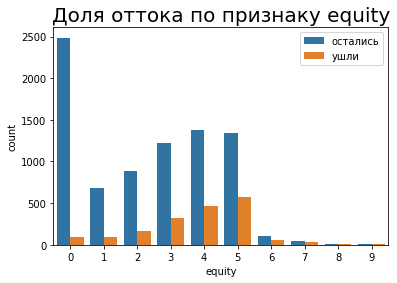

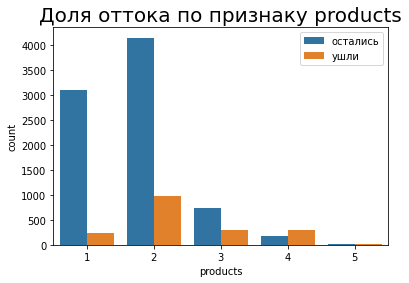

In [25]:
for column in ['city','gender','credit_card','last_activity', 'equity', 'products']:
        ax = sns.countplot(data=data, x=column, hue='churn');
        plt.title(f'Доля оттока по признаку {column}', fontsize = 20, color = 'black')
        plt.legend(['остались', 'ушли'])
        plt.show()        

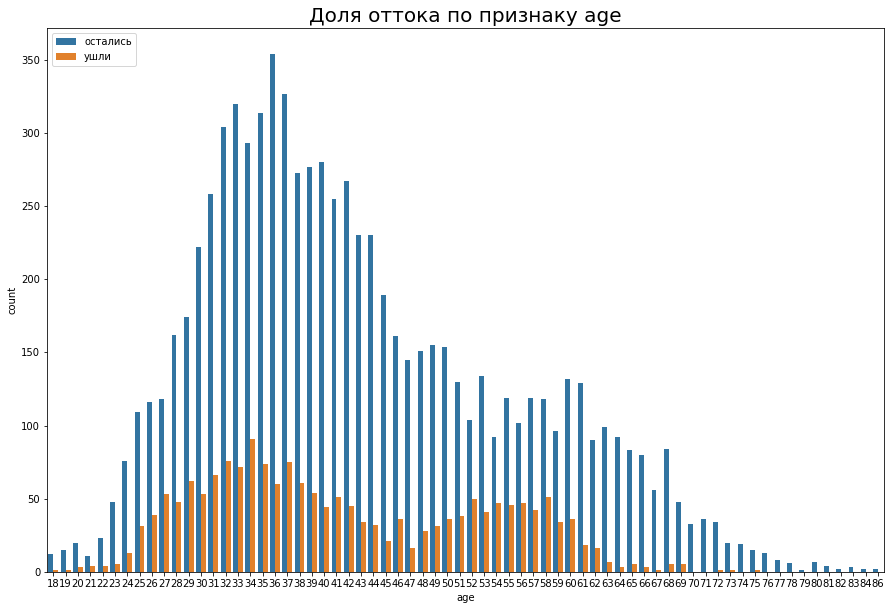

In [26]:
for column in ['age']:
        plt.figure(figsize=(15,10))
        ax = sns.countplot(data=data, x=column, hue='churn');
        plt.title(f'Доля оттока по признаку {column}', fontsize = 20, color = 'black' )
        plt.legend(['остались', 'ушли'])
        plt.show()     

Здесь мы видим, что самый большой отток в Ярославле (там суммарно больше всего клиентов); большинство "оттекающих" - мужчины; чаще такие клиенты имеют кредитную карту, но показатели наличия у обоих категорий практически равны; активных "оттекающих" клиентов значительно больше, чем неактивных "оттекающих", что может быть связано с тем, что люди закрывали счета, забирали деньги из этого банка и совершали другие операции для ухода. Доля отточных клиентов растет с увеличением количества объектов в собственности. Наиболее крупными и подходящими для дальнейшего использования можно назвать клиентов с 4 и 5 объектами. По количеству используемых банковских продуктов можно выделить две группы: клиенты, имеющие 2 продукта, т.к. здесь больше всего людей и достаточно высокий процент оттока (25%); и клиенты, имеющие 4 продукта, т.к. здесь доля оттекающих практически в два раза превышает долю неотточных клиентов, но это малочисленная категория, так что посмотрим, удастся ли нам ее использовать.

### Корреляция признаков

Преобразуем категориальные переменные.

In [27]:
data_dumm = pd.get_dummies(data)
data_dumm.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


Удалим столбец gender_Ж и переименуем столбец gender_М. В новом столбце gender_b: Мужчина - это 1, Женщина - это 0.

In [28]:
data_dumm=data_dumm.drop(['gender_Ж'], axis=1)

In [29]:
data_dumm=data_dumm.rename(columns={"gender_М": "gender_b"})
data_dumm.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_b
0,183012,850,25,1,59214.82,2,0,1,75719.14,1,0,1,0,0
1,146556,861,37,5,850594.33,3,1,0,86621.77,0,0,1,0,0
2,120722,892,30,0,NaN,1,1,1,107683.34,0,0,1,0,0
3,225363,866,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,0
4,157978,730,34,5,174.00,1,1,0,67353.16,1,0,0,1,1


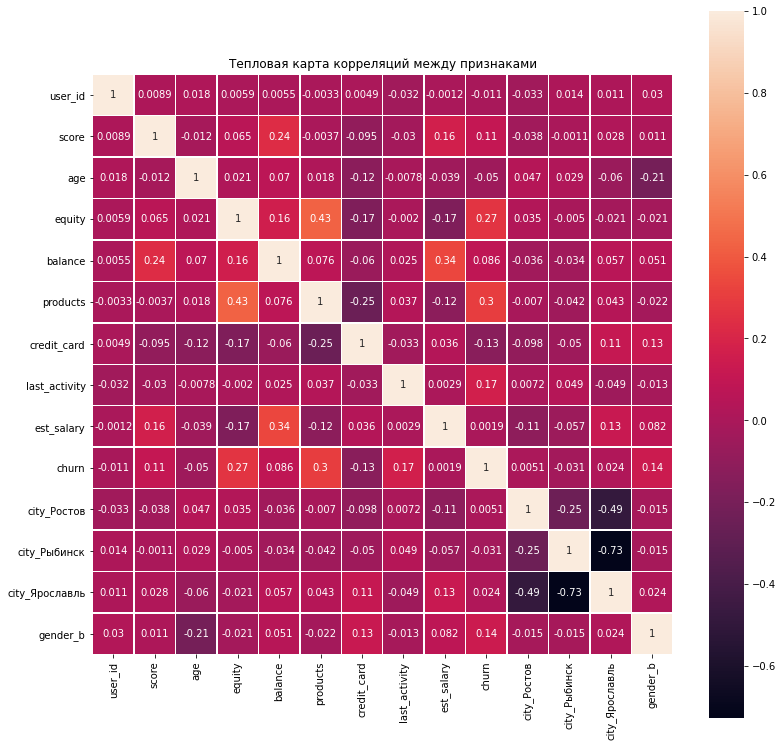

In [30]:
plt.figure(figsize=(13, 13))
sns.heatmap(data_dumm.corr(), square = True, annot = True, linewidths=0.5)
plt.title('Тепловая карта корреляций между признаками')
plt.show()

Сильной зависимости между признаками не наблюдается, есть небольшая связь между оттоком и количеством продуктов (0.3) и баллами собственности (0.27)

В результате исследовательского анализа нам удалось установить следующее:
Большинство клиентов из Ярославля;
68% клинтов используют кредитную карту;
Отток клиентов составляет 18%;
По активности клиенты распределились примерно одинаково: 52% активных и 48% неактивных;
Средний возраст 43 года;
Чаще люди имеют 1-2 банковских продукта;
Клиенты с двумя продуктами чаще уходят;
Самый большой отток заметен в Ярославле.

## Проверка статистических гипотез

Для проверки уровня статистической значимости будем применять t-критерий, так как он используется для проверки того, равны ли средние значения двух выборок при нормальном распределении.

### Гипотеза о различии доходов отточных и оставшихся клиентов

Н0: средние доходы отточных и оставшихся клиентов равны.   
Н1: средние доходы отточных и оставшихся клиентов не равны.

In [31]:
results = st.ttest_ind (
    data[data['churn']==0]['est_salary'],
    data[data['churn']==1]['est_salary'], equal_var = False)

alpha = 0.05

print (results.pvalue) 

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не удалось отвергнуть нулевую гипотезу')

0.8354803526840116
Не удалось отвергнуть нулевую гипотезу


Поскольку не удалось отвергнуть нулевую гипотезу, статистически значимых различий в средних доходах пользователей не наблюдается.

### Гипотеза о влиянии наличия кредитной карты на отточность

Н0: среднее количество кредитных карт у отточных и оставшихся клиентов равно.   
Н1: среднее количество кредитных карт у отточных и оставшихся клиентов не равно.

In [32]:
results = st.ttest_ind (
    data[data['churn']==0]['credit_card'],
    data[data['churn']==1]['credit_card'], equal_var = False)

alpha = 0.05

print (results.pvalue) 

if results.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

3.5339185146511654e-34
Отвергаем нулевую гипотезу


Выявилась статистически значимая разница в количестве кредитных карт у отточных и неотточных клиентов. Доля клиентов с кредитными картами среди неотточных гораздо выше, что было сказано в исследовательском анализе.

## Разделение пользователей на сегменты и их приоритезация

В ходе исследовательского анализа были выявлены наиболее важные параметры клиентов, по которым можно уточнить круг отточных людей. Среди таких категорий: город, пол, количество банковских продуктов, баллы собственности. По этим категориям попытаемся выделить наиболее крупные группы отточных клиентов.

### Сегмент 1:

Включим сюда мужчин из Ярославля с двумя продуктками банка.

Общее число пользователей в сегменте №1: 1373
Число отточных пользователей в сегменте №1: 352
Доля отточных пользователей в сегменте №1: 25.637290604515663


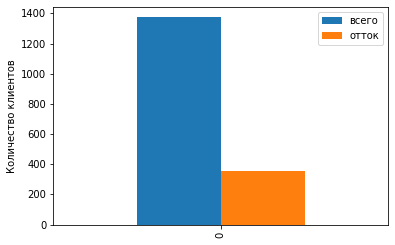

In [33]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №1:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1  and products == 2')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №1:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products == 2 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №1:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products == 2 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products == 2')['user_id'].count()*100)

# Добавим визуализацию
s1 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1  and products == 2')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products == 2 and churn==1')['user_id'].count()]})
s1.plot(kind='bar', ylabel='Количество клиентов')
plt.show()


### Сегмент 2:

Теперь рассмотрим женщин с теми же параметрами.

Общее число пользователей в сегменте №2: 1381
Число отточных пользователей в сегменте №2: 194
Доля отточных пользователей в сегменте №2: 14.047791455467054


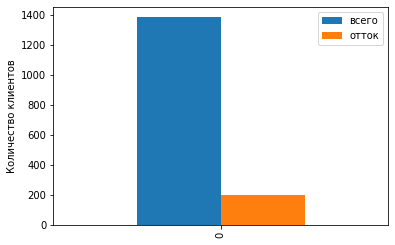

In [34]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №2:', data_dumm.query (
    'gender_b==0 and city_Ярославль==1 and products == 2')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №2:', data_dumm.query (
    'gender_b==0 and city_Ярославль==1 and products == 2 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №2:', data_dumm.query (
    'gender_b==0 and city_Ярославль==1 and products == 2 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==0 and city_Ярославль==1 and products == 2')['user_id'].count()*100)

# Добавим визуализацию
s2 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==0 and city_Ярославль==1 and products == 2')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==0 and city_Ярославль==1 and products == 2 and churn==1')['user_id'].count()]})
s2.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

Слишком маленький процент оттока, этот сегмент нам не подходит.

### Сегмент 3:

 Мужчины из Ярославля с 3-мя и более продуктами банка

Общее число пользователей в сегменте №3: 516
Число отточных пользователей в сегменте №3: 265
Доля отточных пользователей в сегменте №3: 51.356589147286826


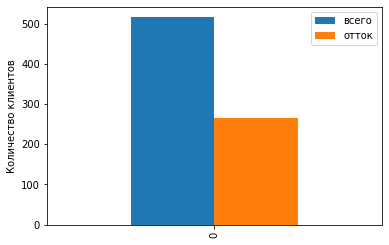

In [35]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №3:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products >= 3')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №3:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products >= 3 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №3:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products >= 3 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products >= 3')['user_id'].count()*100)
# Добавим визуализацию
s3 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products >= 3')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and products >= 3 and churn==1')['user_id'].count()]})
s3.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

Процент хороший, но категория получилась малочисленной. Т.к. количество почти дотягивает до нужного, то учтём эту категорию.

### Сегмент 4:

Мужчины с 3-мя и более продуктами банка.

Общее число пользователей в сегменте №4: 752
Число отточных пользователей в сегменте №4: 376
Доля отточных пользователей в сегменте №4: 50.0


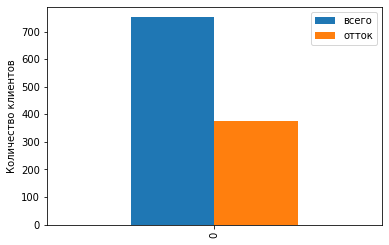

In [36]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №4:', data_dumm.query (
    'gender_b==1 and products >= 3')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №4:', data_dumm.query (
    'gender_b==1 and products >= 3 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №4:', data_dumm.query (
    'gender_b==1 and products >= 3 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==1 and products >= 3')['user_id'].count()*100)
# Добавим визуализацию
s4 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==1 and products >= 3')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==1 and products >= 3 and churn==1')['user_id'].count()]})
s4.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

### Сегмент 5:

Женищны с 3-мя и более продуктами банка

Общее число пользователей в сегменте №5: 779
Число отточных пользователей в сегменте №5: 229
Доля отточных пользователей в сегменте №5: 29.396662387676507


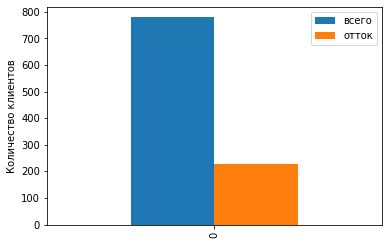

In [37]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №5:', data_dumm.query (
    'gender_b==0 and products >= 3')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №5:', data_dumm.query (
    'gender_b==0 and products >= 3 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №5:', data_dumm.query (
    'gender_b==0 and products >= 3 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==0 and products >= 3')['user_id'].count()*100)

# Добавим визуализацию
s5 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==0 and products >= 3')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==0 and products >= 3 and churn==1')['user_id'].count()]})
s5.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

В данном разрезе нам больше подходят мужчины

### Сегмент 6:

Посмотрим на показатели с разным количеством собственности

Мужчины из Ярославля с 5-ю и более объектами в собственности

Общее число пользователей в сегменте №6: 671
Число отточных пользователей в сегменте №6: 293
Доля отточных пользователей в сегменте №6: 43.666169895678095


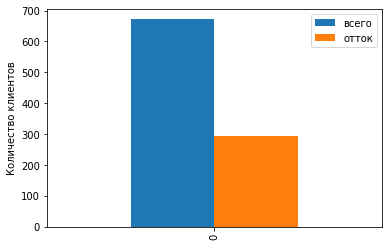

In [38]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №6:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity >= 5')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №6:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity >= 5 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №6:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity >= 5 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity >= 5')['user_id'].count()*100)

# Добавим визуализацию
s6 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity >= 5')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity >= 5 and churn==1')['user_id'].count()]})
s6.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

Группа получилась не слишком большой, удалим город из фильтра и добавим наличие кредитной карты

### Сегмент 7:


Общее число пользователей в сегменте №7: 688
Число отточных пользователей в сегменте №7: 243
Доля отточных пользователей в сегменте №7: 35.31976744186046


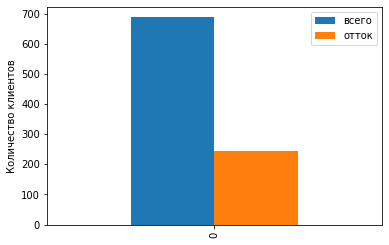

In [39]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №7:', data_dumm.query (
    'gender_b==1 and credit_card == 1 and equity >= 5')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №7:', data_dumm.query (
    'gender_b==1 and credit_card == 1 and equity >= 5 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №7:', data_dumm.query (
    'gender_b==1 and credit_card == 1 and equity >= 5 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==1 and credit_card == 1 and equity >= 5')['user_id'].count()*100)

# Добавим визуализацию
s7 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==1 and credit_card == 1 and equity >= 5')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==1 and credit_card == 1 and equity >= 5 and churn==1')['user_id'].count()]})
s7.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

### Сегмент 8:


Женщины с 5-ю и более объектами в собственности и с кредитной картой

Общее число пользователей в сегменте №8: 597
Число отточных пользователей в сегменте №8: 91
Доля отточных пользователей в сегменте №8: 15.242881072026801


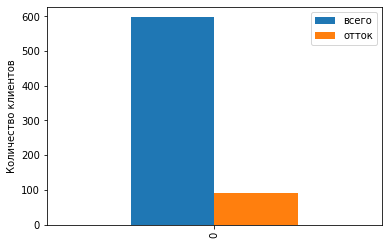

In [40]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №8:', data_dumm.query (
    'gender_b==0 and credit_card == 1 and equity >= 5')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №8:', data_dumm.query (
    'gender_b==0 and credit_card == 1 and equity >= 5 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №8:', data_dumm.query (
    'gender_b==0 and credit_card == 1 and equity >= 5 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==0 and credit_card ==1 and equity >= 5')['user_id'].count()*100)

# Добавим визуализацию
s8 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==0 and credit_card == 1 and equity >= 5')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==0 and credit_card == 1 and equity >= 5 and churn==1')['user_id'].count()]})
s8.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

Женщины с 5-ю и более объектами собственности и с кредиткой значительно реже находятся в оттоке

### Сегмент 9:


Мужчины из Ярославля, имеющие до 5 объектов в собственности

Общее число пользователей в сегменте №9: 2328
Число отточных пользователей в сегменте №9: 417
Доля отточных пользователей в сегменте №9: 17.912371134020617


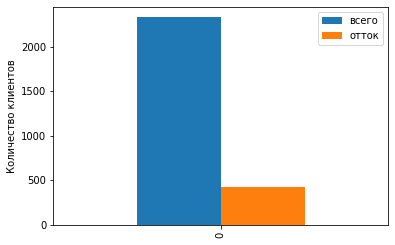

In [41]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №9:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity <= 4')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №9:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity <= 4 and churn==1')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №9:', data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity <= 4 and churn==1')['user_id'].count() / data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity <= 4')['user_id'].count()*100)

# Добавим визуализацию
s9 = pd.DataFrame({'всего': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity <= 4')['user_id'].count()], 'отток': [data_dumm.query (
    'gender_b==1 and city_Ярославль==1 and equity <= 4 and churn==1')['user_id'].count()]})
s9.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

Слишком большая группа и слишком маленький процент оттока

### Сегмент 10:


Клиенты c более чем пятью объектами в собственности, с двумя продуктами банка и без кредитной карты

Общее число пользователей в сегменте №10: 587
Число отточных пользователей в сегменте №10: 224
Доля отточных пользователей в сегменте №10: 38.16013628620102


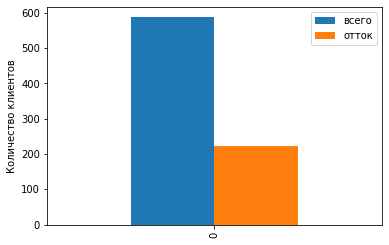

In [42]:
# Рассчитаем общее число пользователей в этом сегменте:
print ('Общее число пользователей в сегменте №10:', data_dumm.query (
    'credit_card == 0  and equity >= 5 and products == 2')['user_id'].count() )


# Рассчитаем число отточных пользователей в этом сегменте:
print ('Число отточных пользователей в сегменте №10:', data_dumm.query (
    'credit_card == 0 and equity >= 5 and churn==1 and products == 2')['user_id'].count())

#  Рассчитаем долю отточных пользователей:
print ('Доля отточных пользователей в сегменте №10:', data_dumm.query (
    'credit_card == 0 and equity >= 5 and churn==1 and products == 2')['user_id'].count() / data_dumm.query (
    'credit_card == 0 and equity >= 5 and products == 2')['user_id'].count()*100)

# Добавим визуализацию
s10 = pd.DataFrame({'всего': [data_dumm.query (
    'credit_card == 0  and equity >= 5 and products == 2')['user_id'].count()], 'отток': [data_dumm.query (
    'credit_card == 0 and equity >= 5 and churn==1 and products == 2')['user_id'].count()]})
s10.plot(kind='bar', ylabel='Количество клиентов')
plt.show()

### Топ-3 сегментов по отточности

Самой отточной является группа мужчин из Ярославля с 3-мя и более продуктами банка (51% оттока); далее идет группа мужчин из Ярославля с 5-ю и более объектами в собственности (44% оттока); замыкает тройку группа клиентов с 5-ю и более объектами в собственности, с двумя продуктами банка и без кредитки. Как сегмент, с непересекающимися с остальными критериями можно назвать десятый, включающий отсутствие кредитной карты, более 5 объектов собственности и два банковских продукта. Женщины хоть и чаще являются клиентами банка, но отточность у них ниже. Чем больше объектов собственности и банковских продуктов у клиента, тем выше его шанс оттока. Отсутствие кредитной карты также является косвенным признаком оттока.

## Вывод

В данном проекте был проведен анализ оттока клиентов банка. В ходе предобработки данных были выявлены и удалены пропуски в возрасте клиентов, т.к. их мало и их отсутствие не скажется на результатах; также были выявлены пропуски я значениях баланса на счете пользователей. Таких пропусков было много и можно было бы предположить, что это нулевые значения при отсутствии таковых в таблице, но это не так и было решено оставить пропуски как есть. Было установлено, что пропуски в балансе не связаны с признаком оттока клиента. Больше всего пропусков было в Ярославле, т.к. из этого города большая часть клиентов и, соответственно, записи с этим городом занимают значительную часть данных. 
Люди моложе 18 лет и с нулевым количеством банковских продуктов не могут являться клиентами банка, поэтому таблица была проверена на наличие таких записей.   

Также было установлено, что всего в отток попало 18% клиентов; клиенты мужского и женского полов разделились поровну; клиентами являются люди от 18 до 86 лет, средний возраст - 43 года; средний балл кредитного скоринга - 849, минимальный - 642, максимальный - 1000; 68% клинтов имеют кредитную карту; активных клиентов 52%; чаще всего клиентами являются люди без собственности; половина клиентов пользуется двумя продуктами банка.   

Большинство "оттекающих" - мужчины; чаще такие клиенты имеют кредитную карту, но показатели наличия у обоих категорий практически равны; активных "оттекающих" клиентов значительно больше, чем неактивных "оттекающих", что может быть связано с тем, что люди закрывали счета, забирали деньги из этого банка и совершали другие операции для ухода. Доля отточных клиентов растет с увеличением количества объектов в собственности. Наиболее крупными и подходящими для дальнейшего использования можно назвать клиентов с 4 и 5 объектами. По количеству используемых банковских продуктов можно выделить две группы: клиенты, имеющие 2 продукта, т.к. здесь больше всего людей и достаточно высокий процент оттока (25%); и клиенты, имеющие 4 продукта, т.к. здесь доля оттекающих практически в два раза превышает долю неотточных клиентов.   

В ходе проверки гипотез было установлено, что статистически значимой разницы в доходах пользователей в оттоке и не в оттоке нет, выявилась статистически значимая разница в количестве кредитных карт у отточных и неотточных клиентов. Доля клиентов с кредитными картами среди неотточных гораздо выше, что было сказано в исследовательском анализе.    

Далее были выделены разрезы пользователей по различным признакам и выделены топ-3 категории, на которые стоит обратить внимание: самой отточной является группа мужчин из Ярославля с 3-мя и более продуктами банка (51% оттока); далее идет группа мужчин из Ярославля с 5-ю и более объектами в собственности (44% оттока); замыкает тройку группа клиентов с 5-ю и более объектами в собственности, с двумя продуктами банка и без кредитки(38% оттока). Женщины хоть и чаще являются клиентами банка, но отточность у них ниже. Чем больше объектов собственности и банковских продуктов у клиента, тем выше его шанс оттока. Отсутствие кредитной карты также является косвенным признаком оттока.


## Рекомендации

Учитывая количество отточных клиентов в Ярославле, сотрудникам банка в этом городе,как в целом и в других филиалах, следует уделить внимание мужчинам, клиентам с большим количеством собственности, с тремя и боле продуктами банка и без кредитной карты. В частности, мужчинам можно предложить скидки на топливо, в автомобильных магазинах, как вариант на товары для рыболовов; по поводу имущества можно предложить понижение стоимости страховки либо какие-то дополнительные услуги по выгодной цене; клиентам, не имеющим кредитную карту, стоит ее предложить; если считать, что банковскими продуктами являются кредитные карты, различные кредиты и тому подобные вещи, то можно предложить перекредитование под более выгодный процент, кредитные карты с повышенным кэшбеком, увеличенной суммой и сроком возврата задолженности.